In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pathlib import Path
import gc
from tqdm import tqdm
import math
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import r2_score
from prj.config import DATA_DIR
from prj.data.data_loader import DataConfig, DataLoader

2024-12-23 13:11:40.028963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-23 13:11:40.028992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-23 13:11:40.030240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 13:11:40.036574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 13:11:40.906738: W tensorflow/compiler/tf2

In [2]:
data_args = {}
config = DataConfig(**data_args)
loader = DataLoader(data_dir=DATA_DIR, config=config)

end_date = 1250
train_ds = loader.load(1100, end_date)
val_ds = loader.load(end_date + 1, end_date + 1 + 50)

In [3]:
params = {'n_estimators': 200, 'max_depth': 3, 'num_leaves': 8, 'learning_rate': 5e-2}

In [4]:
def evaluate_model(model, X_train, y_train, X_val, y_val, weights, feature_names, cat_features=[]):   
    cat_features_idx = [feature_names.index(f) for f in cat_features]
    if len(cat_features_idx) > 0:
        print(f'Using categorical features: {cat_features_idx}')
    model.fit(X_train, y_train, feature_name=feature_names, categorical_feature=','.join([str(c) for c in cat_features_idx]))
    pred_val = model.predict(X_val).clip(-5, 5)
    return r2_score(y_val, pred_val, sample_weight=weights)

In [5]:
X_train, y_train, w_train, _ = loader._build_splits(train_ds)
X_val, y_val, w_val, _ = loader._build_splits(val_ds)
model = LGBMRegressor(**params)

evaluate_model(model, X_train, y_train, X_val, y_val, w_val, loader.features)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.511436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19335
[LightGBM] [Info] Number of data points in the train set: 5638600, number of used features: 79
[LightGBM] [Info] Start training from score -0.000730


0.006167946126163559

In [6]:
def wrapper_pbar(pbar, func):
    def foo(*args, **kwargs):
        pbar.update(1)
        return func(*args, **kwargs)
    return foo

In [7]:
from sklearn.metrics import pairwise_distances


def _knn_features(df: pl.DataFrame, 
                         period: int,
                         schema: dict,
                         features: list[str],
                         target: str,
                         knn_windows: list[int],
                         aggs: list[str]) -> pl.DataFrame:
    
    min_date = df['date_id'].min()
    min_time = df['time_id'].min()
    max_date = df['date_id'].max()
    max_time = df['time_id'].max()
    # symbol_id = df['symbol_id'].unique().item()
    # print(f"{df.shape}, [{min_date} - {max_date}] [{min_time} - {max_time}] , days={(max_date - min_date)}, period={period}, symbol_id={symbol_id}")

    base_cols = ['date_id', 'time_id', 'symbol_id', target]
    if (max_date - min_date) != period:
        print(f"{df.shape}, [{min_date} - {max_date}] [{min_time} - {max_time}] , days={(max_date - min_date)}, period={period}")
        return pl.DataFrame({}, schema=schema)
    
    df = df.fill_nan(None).drop_nulls()
    
    symbols = df['symbol_id'].unique().to_numpy()
    final_res = pl.DataFrame({}, schema)
    for symbol_id in symbols:
        target_samples = df.filter(
            pl.col('date_id') == max_date,
            pl.col('symbol_id') == symbol_id,
        ).select(features).to_numpy()
        
        res = df.filter(
            pl.col('date_id') == max_date,
            pl.col('symbol_id') == symbol_id
        ).select(base_cols)
        
        samples = df.filter(
            pl.col('date_id') < max_date,
            pl.col('symbol_id') == symbol_id,
        ).select(features + [target]).to_numpy()
        
        if target_samples.shape[0] == 0 or samples.shape[0] == 0:
            print(f"No samples for symbol_id={symbol_id} {min_date}-{max_date}")
            continue
            
        distances = pairwise_distances(target_samples, samples[:, :-1])
        sorted_indices = np.argsort(distances, axis=-1)
        for n in knn_windows:
            if n > distances.shape[1]:
                print(f'Not enough samples to compute knn with window {n} and distances shape {distances.shape}')
                continue # not enough samples to compute knn with that window

            nearest_indices = sorted_indices[:, :n]        
            knn_targets: np.ndarray = samples[nearest_indices.flatten(), -1].reshape(target_samples.shape[0], n)
            col_name = f'{target}_knn_{n}'
            for agg in aggs:
                agg_name = f'{col_name}_{agg}'
                if agg == 'mean':
                    res = res.with_columns(
                        pl.Series(np.mean(knn_targets, axis=-1)).alias(agg_name),
                    )
                elif agg == 'weighted_mean':
                    knn_distances = distances[np.arange(distances.shape[0])[:, None], nearest_indices]
                    weights = 1 / (knn_distances + 1e-8)
                    weights /= np.sum(weights, axis=-1, keepdims=True)
                    res = res.with_columns(
                        pl.Series(np.mean(knn_targets * weights, axis=-1)).alias(agg_name)
                    )
                elif agg == 'positive_ratio':
                    res = res.with_columns(
                        pl.Series(np.mean(knn_targets > 0, axis=-1)).alias(agg_name)
                    )
                else:
                    raise ValueError(f'Unknown aggregation {agg}')
        final_res = final_res.vstack(res.select(*list(schema.keys())).cast(schema))
                    
    return final_res.select(*list(schema.keys())).cast(schema)

In [8]:
schema = {'date_id': pl.Int16, 'time_id': pl.Int16, 'symbol_id': pl.Int8, 'responder_6': pl.Float32}
target = 'responder_6'
knn_windows = [200, 500, 1000]
aggs = ['mean', 'weighted_mean', 'positive_ratio']
features = loader.features
schema.update({
    f'{target}_knn_{n}_{agg}': pl.Float32
    for n in knn_windows
    for agg in aggs
})

df = pl.concat([train_ds, val_ds], how='vertical')

period=7
n_dates = df.select('date_id').unique().count().collect().item()
num_groups = max(0, n_dates - period + 1)

with tqdm(total=int(num_groups)) as pbar:
    knn_df = df.sort('date_id', 'time_id').group_by_dynamic(
        pl.col('date_id').cast(pl.Int64),
        period=f"{period}i",
        every="1i",
        closed='both',
    ).map_groups(
        wrapper_pbar(
            pbar, 
            lambda x: _knn_features(x, period, schema, features, target, knn_windows, aggs)
        ),
        schema=schema
    ).drop(target)\
    .collect()
    
knn_df.head()

  5%|▍         | 9/196 [01:52<41:45, 13.40s/it]

No samples for symbol_id=27 1108-1115


  9%|▊         | 17/196 [03:41<40:34, 13.60s/it]

No samples for symbol_id=32 1116-1123


  9%|▉         | 18/196 [03:55<40:32, 13.67s/it]

No samples for symbol_id=32 1117-1124


 34%|███▍      | 67/196 [15:46<29:35, 13.76s/it]

No samples for symbol_id=28 1166-1173


 36%|███▌      | 70/196 [16:27<28:42, 13.67s/it]

No samples for symbol_id=4 1169-1176


 38%|███▊      | 75/196 [17:35<27:24, 13.59s/it]

No samples for symbol_id=4 1174-1181


 41%|████      | 80/196 [18:42<25:57, 13.42s/it]

No samples for symbol_id=35 1179-1186


 43%|████▎     | 85/196 [19:50<25:44, 13.92s/it]

No samples for symbol_id=21 1184-1191


 44%|████▍     | 86/196 [20:06<26:16, 14.33s/it]

No samples for symbol_id=8 1185-1192


 45%|████▍     | 88/196 [20:36<26:39, 14.81s/it]

No samples for symbol_id=0 1187-1194
No samples for symbol_id=1 1187-1194
No samples for symbol_id=7 1187-1194
No samples for symbol_id=9 1187-1194
No samples for symbol_id=10 1187-1194
No samples for symbol_id=16 1187-1194
No samples for symbol_id=33 1187-1194


 46%|████▋     | 91/196 [21:15<23:50, 13.63s/it]

No samples for symbol_id=7 1190-1197


 48%|████▊     | 94/196 [21:59<25:01, 14.72s/it]

No samples for symbol_id=15 1193-1200


 48%|████▊     | 95/196 [22:16<25:46, 15.32s/it]

No samples for symbol_id=3 1194-1201
No samples for symbol_id=18 1194-1201
No samples for symbol_id=27 1194-1201


 49%|████▉     | 97/196 [22:42<23:23, 14.18s/it]

No samples for symbol_id=3 1196-1203
No samples for symbol_id=19 1196-1203
No samples for symbol_id=22 1196-1203


 50%|█████     | 98/196 [22:55<22:25, 13.73s/it]

No samples for symbol_id=5 1197-1204


 51%|█████     | 99/196 [23:08<21:44, 13.45s/it]

No samples for symbol_id=18 1198-1205


 51%|█████     | 100/196 [23:21<21:27, 13.41s/it]

No samples for symbol_id=22 1199-1206


 52%|█████▏    | 102/196 [23:47<20:40, 13.20s/it]

No samples for symbol_id=22 1201-1208


 53%|█████▎    | 104/196 [24:13<20:13, 13.19s/it]

No samples for symbol_id=11 1203-1210


 54%|█████▎    | 105/196 [24:26<19:56, 13.15s/it]

No samples for symbol_id=18 1204-1211


 55%|█████▌    | 108/196 [25:06<19:28, 13.28s/it]

No samples for symbol_id=17 1207-1214


 56%|█████▌    | 109/196 [25:19<19:10, 13.22s/it]

No samples for symbol_id=20 1208-1215
No samples for symbol_id=27 1208-1215


 57%|█████▋    | 111/196 [25:45<18:39, 13.17s/it]

No samples for symbol_id=5 1210-1217
No samples for symbol_id=35 1210-1217


 57%|█████▋    | 112/196 [25:58<18:13, 13.02s/it]

No samples for symbol_id=28 1211-1218


 58%|█████▊    | 113/196 [26:11<17:51, 12.91s/it]

No samples for symbol_id=15 1212-1219
No samples for symbol_id=18 1212-1219
No samples for symbol_id=19 1212-1219
No samples for symbol_id=21 1212-1219
No samples for symbol_id=27 1212-1219


 61%|██████    | 119/196 [27:27<16:36, 12.94s/it]

No samples for symbol_id=17 1218-1225


 61%|██████    | 120/196 [27:40<16:33, 13.07s/it]

No samples for symbol_id=37 1219-1226


 63%|██████▎   | 123/196 [28:19<16:05, 13.22s/it]

No samples for symbol_id=13 1222-1229


 64%|██████▍   | 125/196 [28:46<15:41, 13.26s/it]

No samples for symbol_id=13 1224-1231


 66%|██████▋   | 130/196 [30:04<16:07, 14.65s/it]

No samples for symbol_id=0 1229-1236
No samples for symbol_id=1 1229-1236
No samples for symbol_id=2 1229-1236
No samples for symbol_id=3 1229-1236
No samples for symbol_id=4 1229-1236
No samples for symbol_id=5 1229-1236
No samples for symbol_id=6 1229-1236
No samples for symbol_id=7 1229-1236
No samples for symbol_id=8 1229-1236
No samples for symbol_id=9 1229-1236
No samples for symbol_id=10 1229-1236
No samples for symbol_id=11 1229-1236
No samples for symbol_id=12 1229-1236
No samples for symbol_id=13 1229-1236
No samples for symbol_id=14 1229-1236
No samples for symbol_id=15 1229-1236
No samples for symbol_id=16 1229-1236
No samples for symbol_id=17 1229-1236
No samples for symbol_id=18 1229-1236
No samples for symbol_id=19 1229-1236
No samples for symbol_id=20 1229-1236
No samples for symbol_id=21 1229-1236
No samples for symbol_id=22 1229-1236
No samples for symbol_id=23 1229-1236
No samples for symbol_id=24 1229-1236
No samples for symbol_id=25 1229-1236
No samples for symbol_

 67%|██████▋   | 131/196 [30:04<11:19, 10.46s/it]

No samples for symbol_id=29 1229-1236
No samples for symbol_id=30 1229-1236
No samples for symbol_id=31 1229-1236
No samples for symbol_id=32 1229-1236
No samples for symbol_id=33 1229-1236
No samples for symbol_id=34 1229-1236
No samples for symbol_id=35 1229-1236
No samples for symbol_id=36 1229-1236
No samples for symbol_id=37 1229-1236
No samples for symbol_id=38 1229-1236


 68%|██████▊   | 133/196 [30:27<11:32, 11.00s/it]

No samples for symbol_id=0 1232-1239
No samples for symbol_id=1 1232-1239
No samples for symbol_id=2 1232-1239
No samples for symbol_id=3 1232-1239
No samples for symbol_id=4 1232-1239
No samples for symbol_id=5 1232-1239
No samples for symbol_id=6 1232-1239
No samples for symbol_id=7 1232-1239
No samples for symbol_id=8 1232-1239
No samples for symbol_id=9 1232-1239
No samples for symbol_id=10 1232-1239
No samples for symbol_id=11 1232-1239
No samples for symbol_id=12 1232-1239
No samples for symbol_id=13 1232-1239
No samples for symbol_id=14 1232-1239
No samples for symbol_id=15 1232-1239
No samples for symbol_id=16 1232-1239
No samples for symbol_id=17 1232-1239
No samples for symbol_id=18 1232-1239
No samples for symbol_id=19 1232-1239
No samples for symbol_id=20 1232-1239
No samples for symbol_id=21 1232-1239
No samples for symbol_id=22 1232-1239
No samples for symbol_id=23 1232-1239
No samples for symbol_id=24 1232-1239
No samples for symbol_id=25 1232-1239
No samples for symbol_

 68%|██████▊   | 134/196 [30:28<08:08,  7.89s/it]

No samples for symbol_id=32 1232-1239
No samples for symbol_id=33 1232-1239
No samples for symbol_id=34 1232-1239
No samples for symbol_id=35 1232-1239
No samples for symbol_id=36 1232-1239
No samples for symbol_id=37 1232-1239
No samples for symbol_id=38 1232-1239


 69%|██████▉   | 135/196 [30:37<08:32,  8.40s/it]

No samples for symbol_id=3 1234-1241


 70%|██████▉   | 137/196 [30:56<08:42,  8.86s/it]

No samples for symbol_id=26 1236-1243


 71%|███████▏  | 140/196 [31:28<09:28, 10.16s/it]

No samples for symbol_id=1 1239-1246
No samples for symbol_id=3 1239-1246
No samples for symbol_id=5 1239-1246
No samples for symbol_id=9 1239-1246
No samples for symbol_id=11 1239-1246
No samples for symbol_id=12 1239-1246
No samples for symbol_id=17 1239-1246
No samples for symbol_id=23 1239-1246
No samples for symbol_id=32 1239-1246


 72%|███████▏  | 141/196 [31:37<08:58,  9.79s/it]

No samples for symbol_id=1 1240-1247
No samples for symbol_id=3 1240-1247
No samples for symbol_id=5 1240-1247
No samples for symbol_id=9 1240-1247
No samples for symbol_id=11 1240-1247
No samples for symbol_id=12 1240-1247
No samples for symbol_id=17 1240-1247
No samples for symbol_id=23 1240-1247
No samples for symbol_id=32 1240-1247


 81%|████████  | 159/196 [35:33<08:22, 13.57s/it]

No samples for symbol_id=25 1258-1265
No samples for symbol_id=29 1258-1265


 82%|████████▏ | 160/196 [35:46<08:00, 13.36s/it]

No samples for symbol_id=32 1259-1266


 83%|████████▎ | 162/196 [36:13<07:31, 13.27s/it]

No samples for symbol_id=9 1261-1268
No samples for symbol_id=25 1261-1268
No samples for symbol_id=29 1261-1268


 83%|████████▎ | 163/196 [36:25<07:10, 13.04s/it]

No samples for symbol_id=9 1262-1269
No samples for symbol_id=27 1262-1269


 84%|████████▎ | 164/196 [36:38<06:53, 12.92s/it]

No samples for symbol_id=9 1263-1270


 84%|████████▍ | 165/196 [36:51<06:40, 12.93s/it]

No samples for symbol_id=9 1264-1271


 85%|████████▍ | 166/196 [37:04<06:28, 12.94s/it]

No samples for symbol_id=9 1265-1272
No samples for symbol_id=28 1265-1272


 85%|████████▌ | 167/196 [37:16<06:12, 12.83s/it]

No samples for symbol_id=9 1266-1273


 86%|████████▌ | 168/196 [37:29<06:00, 12.88s/it]

No samples for symbol_id=9 1267-1274


 88%|████████▊ | 172/196 [38:22<05:13, 13.08s/it]

No samples for symbol_id=18 1271-1278


 88%|████████▊ | 173/196 [38:35<04:59, 13.03s/it]

No samples for symbol_id=36 1272-1279


 90%|█████████ | 177/196 [39:27<04:09, 13.12s/it]

No samples for symbol_id=6 1276-1283
No samples for symbol_id=32 1276-1283


 95%|█████████▍| 186/196 [41:24<02:10, 13.06s/it]

No samples for symbol_id=10 1285-1292
No samples for symbol_id=35 1285-1292
No samples for symbol_id=36 1285-1292


 96%|█████████▌| 188/196 [41:49<01:43, 12.90s/it]

No samples for symbol_id=29 1287-1294


 96%|█████████▋| 189/196 [42:02<01:29, 12.85s/it]

No samples for symbol_id=12 1288-1295


 97%|█████████▋| 190/196 [42:14<01:16, 12.80s/it]

No samples for symbol_id=9 1289-1296


100%|██████████| 196/196 [43:33<00:00, 13.11s/it]

(263296, 93), [1295 - 1301] [0 - 967] , days=6, period=7
(226512, 93), [1296 - 1301] [0 - 967] , days=5, period=7
(188760, 93), [1297 - 1301] [0 - 967] , days=4, period=7
(151008, 93), [1298 - 1301] [0 - 967] , days=3, period=7
(113256, 93), [1299 - 1301] [0 - 967] , days=2, period=7
(75504, 93), [1300 - 1301] [0 - 967] , days=1, period=7
(37752, 93), [1301 - 1301] [0 - 967] , days=0, period=7


202it [43:33, 12.94s/it]                         


date_id,time_id,symbol_id,responder_6_knn_5_mean,responder_6_knn_5_weighted_mean,responder_6_knn_5_positive_ratio,responder_6_knn_10_mean,responder_6_knn_10_weighted_mean,responder_6_knn_10_positive_ratio,responder_6_knn_50_mean,responder_6_knn_50_weighted_mean,responder_6_knn_50_positive_ratio,responder_6_knn_100_mean,responder_6_knn_100_weighted_mean,responder_6_knn_100_positive_ratio,responder_6_knn_200_mean,responder_6_knn_200_weighted_mean,responder_6_knn_200_positive_ratio,responder_6_knn_500_mean,responder_6_knn_500_weighted_mean,responder_6_knn_500_positive_ratio
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1107,68,0,0.828495,0.166091,1.0,0.697924,0.070006,0.9,0.418798,0.008601,0.82,0.33228,0.003421,0.75,0.266606,0.001376,0.685,0.186591,0.000391,0.64
1107,69,0,0.810712,0.163905,1.0,0.725444,0.07346,0.9,0.424512,0.008687,0.82,0.400802,0.004071,0.78,0.256904,0.001342,0.665,0.16901,0.00036,0.624
1107,70,0,0.386974,0.077289,1.0,0.265882,0.026752,0.8,0.446122,0.008899,0.84,0.359042,0.003636,0.79,0.253681,0.001308,0.68,0.106688,0.000238,0.602
1107,71,0,0.22421,0.045164,0.8,0.336902,0.03333,0.9,0.387227,0.007735,0.78,0.275477,0.002814,0.72,0.207663,0.001074,0.655,0.083289,0.000187,0.578
1107,72,0,0.391516,0.07809,0.8,0.340566,0.034304,0.8,0.404404,0.008077,0.82,0.332449,0.003361,0.77,0.201189,0.001054,0.655,0.097256,0.000216,0.596


In [9]:
df_knn = df.join(knn_df.lazy(), on=['date_id', 'time_id', 'symbol_id'], how='left')
df_knn.head()

In [10]:
knn_features = [col for col in schema.keys() if col not in ['date_id', 'time_id', 'symbol_id', target]]
knn_features

['responder_6_knn_5_mean',
 'responder_6_knn_5_weighted_mean',
 'responder_6_knn_5_positive_ratio',
 'responder_6_knn_10_mean',
 'responder_6_knn_10_weighted_mean',
 'responder_6_knn_10_positive_ratio',
 'responder_6_knn_50_mean',
 'responder_6_knn_50_weighted_mean',
 'responder_6_knn_50_positive_ratio',
 'responder_6_knn_100_mean',
 'responder_6_knn_100_weighted_mean',
 'responder_6_knn_100_positive_ratio',
 'responder_6_knn_200_mean',
 'responder_6_knn_200_weighted_mean',
 'responder_6_knn_200_positive_ratio',
 'responder_6_knn_500_mean',
 'responder_6_knn_500_weighted_mean',
 'responder_6_knn_500_positive_ratio']

In [11]:
loader.features += knn_features
loader.features

['feature_00',
 'feature_01',
 'feature_02',
 'feature_03',
 'feature_04',
 'feature_05',
 'feature_06',
 'feature_07',
 'feature_08',
 'feature_09',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_

In [12]:
train_ds = df_knn.filter(pl.col('date_id') <= end_date)
val_ds = df_knn.filter(pl.col('date_id') > end_date)

X_train, y_train, w_train, _ = loader._build_splits(train_ds)
X_val, y_val, w_val, _ = loader._build_splits(val_ds)

model = LGBMRegressor(**params)
evaluate_model(model, X_train, y_train, X_val, y_val, w_val, feature_names=loader.features)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.508182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22993
[LightGBM] [Info] Number of data points in the train set: 5638600, number of used features: 97
[LightGBM] [Info] Start training from score -0.000730


0.006578449310420509

<Axes: title={'center': 'Feature importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

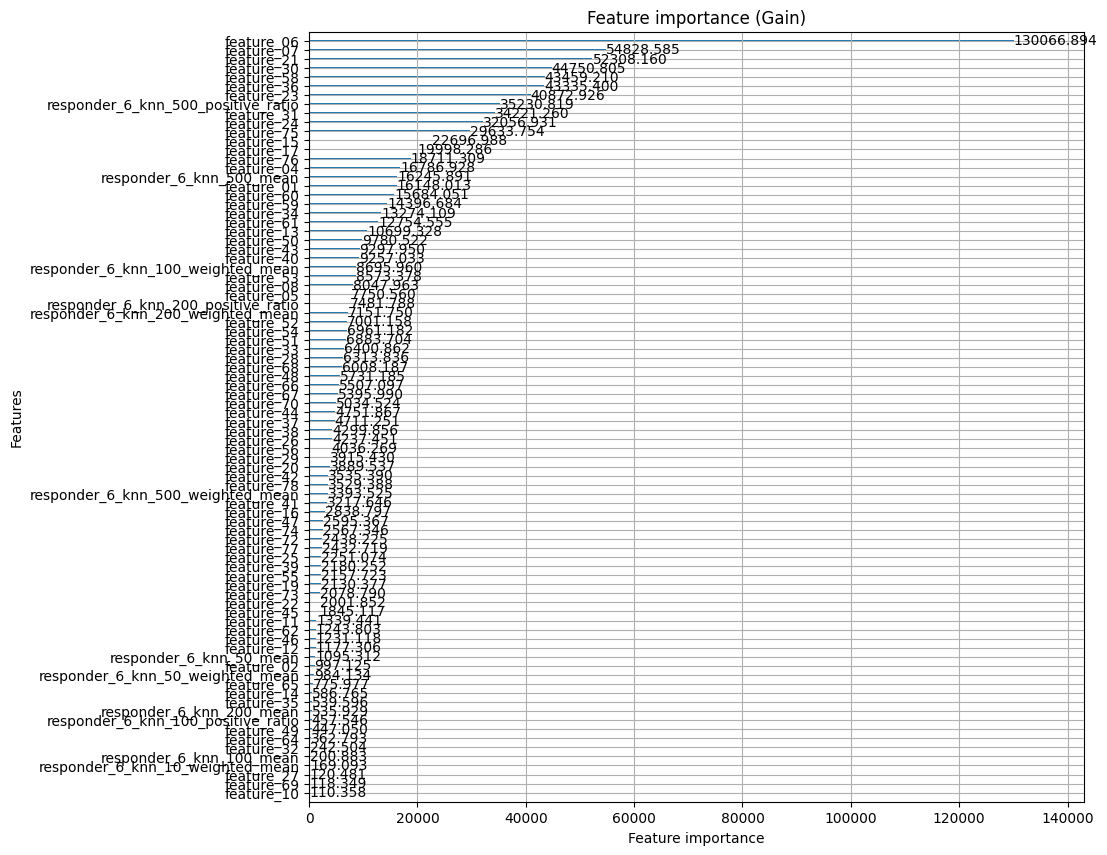

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(model, importance_type='gain', title='Feature importance (Gain)', ax=ax)